# What is this data?

This is an export of all the metadata of all papers from 2011 until 2023 that mention "misinformation" in any of its data.

# Why this data?

I'm interested in the evolutin of misinformation literature over time, particularly before and after the 2016 election. My working theory is that misinformation, i.e. people saying/believing false things, is not a productive framing. To be sure, something is happening, but, after reading a good amount of misinformation literature, I have a early, loosely related ideas, and I'd like to see if they're right, expand them, tie them together, etc.

* The post-2016 spike in the term "misinformation" was obviously an attempt to understand why Trump had won the 2016 election. Academics, for reasons, feel the need to remain neutral, which birthed a whole host of politically neutral frameworks: misinformation, polarization, partisanship, bias, trust in institutions, and so on. Ultimately, I think that this has turned into a series of politce euphemisms that detract from meaningful engagement with substantive political and ideological shifts happening in our society.
* Much of this research uses social media data. Researchers are looking for an emergent patterns in data that was explicitly structured already. Social media companies are active participants with their own institutions and incentives, yet many papers acknowledge them only insofar as they exist and could maybe moderate better in the future
* You cannot build a truth machine. It is literally impossible to detect "misinformation" as such. The vast majority of what we say cannot be attributed to true/false binaries. Utterances like "the pope is dead," (which pope? The current one is alive but, statistically, most are dead.) "I'm hungry," "the US is a force for democracy in the world" require context. Many papers try to get around this by using sources as proxies: They look at tweets that link to different news sources, then any tweet with an unreliable source is labeled as misinformation, and any tweet with a reliable source is labeled as truth. This is a grotesque simplification.
* People's brains don't store an agglomeration of unrelated facts. We don't store data to recall later because our brain is not a hard drive. Anyone who has taught knows that, sure, we do teach facts, but we also teach frameworks, patterns, and structure. Thinking is a process with a beginning and a (temporary?) end, often done in collaboration.
    * Attempting to think on social meida involves broadcasting initial thoughts into non-collaborative, often hostile environments where they persist despite the lack of engagement. Is this a problem of "misinformation" or is this just a bad way to learn?


In [56]:
import pandas as pd
df = pd.read_csv('data.csv')

In [2]:
len(df)

14689

In [6]:
len(df.columns)

25

In [7]:
top_citations = df[df['Cited by'] > 50]
len(top_citations)

1460

In [8]:
top_citations.sort_values('Cited by', ascending=[False])['Title'].head(50)

10360    COVID-19 and mental health: A review of the ex...
935      “So what if ChatGPT wrote it?” Multidisciplina...
14360    Misinformation and Its Correction: Continued I...
14665                   Information credibility on Twitter
13448               The spreading of misinformation online
12677    Defining “Fake News”: A typology of scholarly ...
14622    Why do humans reason? Arguments for an argumen...
10312    Vaccine hesitancy: the next challenge in the f...
9840                   The COVID-19 social media infodemic
10461    Fighting COVID-19 Misinformation on Social Med...
8481     Measuring the impact of COVID-19 vaccine misin...
10699    Response to COVID-19 in Taiwan: Big Data Analy...
11594    Systematic Literature Review on the Spread of ...
12892    Beyond Misinformation: Understanding and Copin...
10578    Suicide risk and prevention during the COVID-1...
12841    Mind the Hype: A Critical Evaluation and Presc...
14509                 Opioid epidemic in the united stat

<Axes: ylabel='Frequency'>

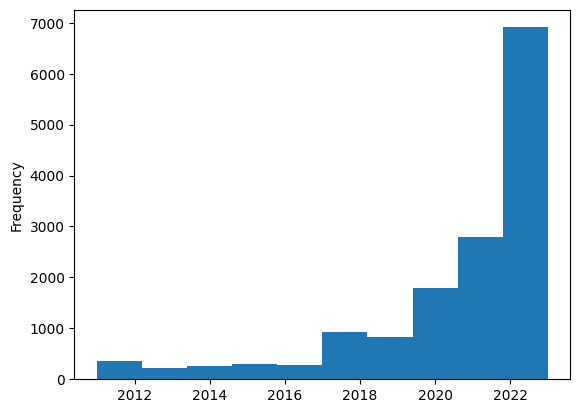

In [9]:
df['Year'].plot.hist()

I want to look at how the concepts involved in this research have drifted through time. To get an early feel, I'll write a function called `word_density` that plots what percentage of papers have a list of words on the y axis with the year on the x axis. I'm going to plot both all papers and the ones with >50 citations.

In [37]:
def word_density(words):
    found = pd.DataFrame(
        df[df['Abstract'].str.contains('|'.join(words), case=False)].groupby('Year')['Abstract'].count()
    )
    top_citations_found = pd.DataFrame(
        top_citations[
            top_citations['Abstract'].str.contains('|'.join(words), case=False)
            ].groupby('Year')['Abstract'].count()
    )
    counts = pd.DataFrame(
        df.groupby('Year')['Abstract'].count()
    )
    counts_tc = pd.DataFrame(top_citations.groupby('Year')['Abstract'].count())
    merged = found.merge(counts, on='Year')
    merged_tc = top_citations_found.merge(counts_tc, on="Year")
    
    final = pd.DataFrame({
        'all': merged['Abstract_x']/merged['Abstract_y'] * 100,
        'top citations': merged_tc['Abstract_x']/merged_tc['Abstract_y'] * 100
    })
    final.plot.line()


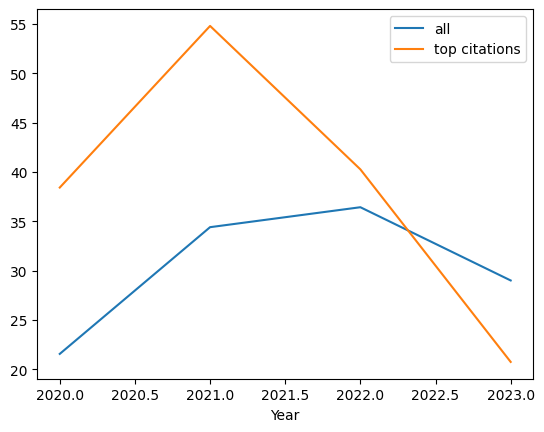

In [45]:
# A nice sanity check. It'd be pretty nuts if this started before 2020!
word_density(['covid'])

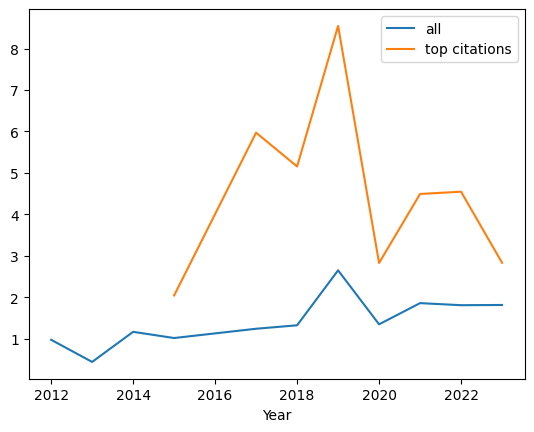

In [46]:
word_density(['partisan'])

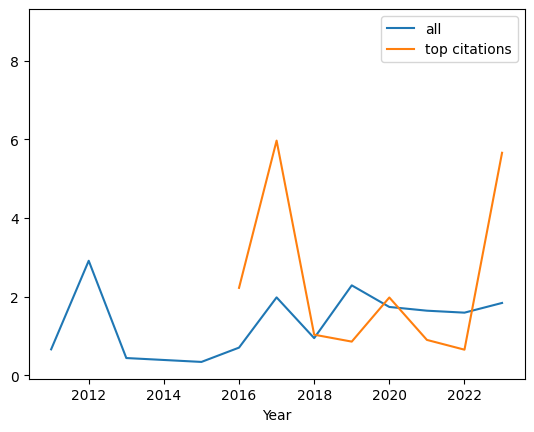

In [47]:
word_density(['democracy'])

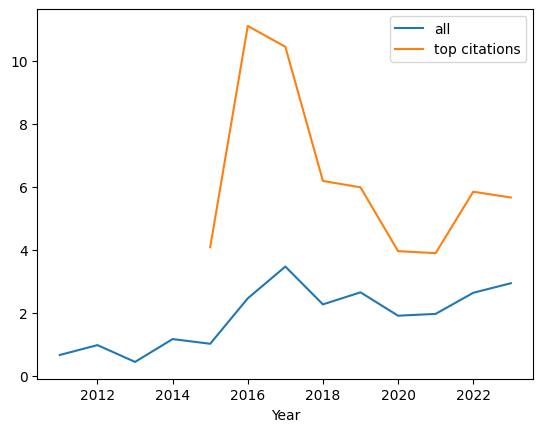

In [48]:
word_density(['polariz'])

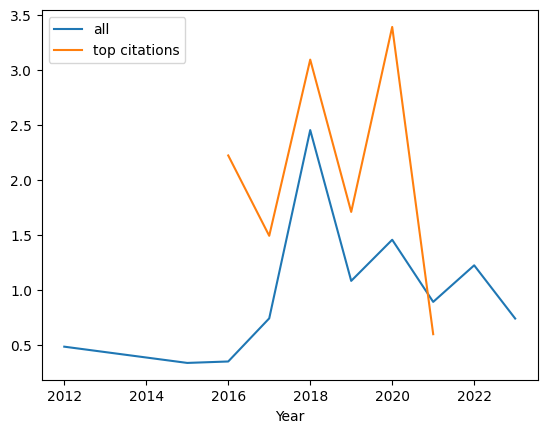

In [40]:
word_density(['trump'])

Now I'll clean the abstracts to do some light NLP. I'll just remove punctuation and make everything lowercase. I'll also save that specific dataset to its own CSV to poke around on emacs. I won't stem for now because that makes them impossible to read, and most of the things I'm interested tend to stay as nice nouns. No one "misinformates," for example.

In [42]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

import string

def clean_abstract(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    new_text = []
    for word in text.split():
        if word not in (stop):
            new_text.append(word)
    return ' '.join(new_text).lower()

df['abstract_cleaned'] = df['Abstract'].apply(clean_abstract)
df[['abstract_cleaned', 'Year']].to_csv('abstract_cleaned_per_year.csv')
df['abstract_cleaned']

0        during public health crises public trust essen...
1        infectious disease outbreaks covid19 pandemic ...
2        in 2019 united kingdom uk lost measles free st...
3        this work analyzes role images vehicle spread ...
4        objective this study carried determine percept...
                               ...                        
14684    witnesses discuss event others often incorpora...
14685    this study compared adults assess credibility ...
14686    this paper established new direction researche...
14687    people remember different details events discu...
14688    objective to assess racial differences attitud...
Name: abstract_cleaned, Length: 14689, dtype: object

Now I'd like to use the VSCS-created tool, the shifterator, to look at the changes in the words being used in a periodized corpus. This looks at the relative changes in word frequency between two corpora and gives you a nice graph with the words used most differently between the two quantified.

In [19]:
import os
from py_allotax.generate_svg import generate_svg
import csv
import shifterator as sh

data = None
new = []
old = []
covid=[]

with open('abstract_cleaned_per_year.csv', 'r') as f:
    data = csv.reader(f)
    for i, row in enumerate(data):
        if i == 0:
            continue
        text = row[1]
        year = row[2]

        if int(year) > 2016 and int(year) < 2020:
            new.append(text)
        elif int(year) <= 2016:
            old.append(text)
        elif int(year) >= 2020:
            covid.append(text)

covid = ' '.join(covid)
new = ' '.join(new)
old = ' '.join(old)


In [20]:
junk = [str(2010 + i) for i in range(15)]
junk.extend(['©', 'Elsevier'])

def make_freqdist(bow):
    return FreqDist([
        word.lower() for word in bow.split() 
        if word not in stopwords.words('english') and word not in junk
    ])

from nltk import tokenize, FreqDist, bigrams

covid = make_freqdist(covid)
new = make_freqdist(new)
old = make_freqdist(old)
covid = make_freqdist(covid)


AttributeError: 'YTick' object has no attribute 'label'

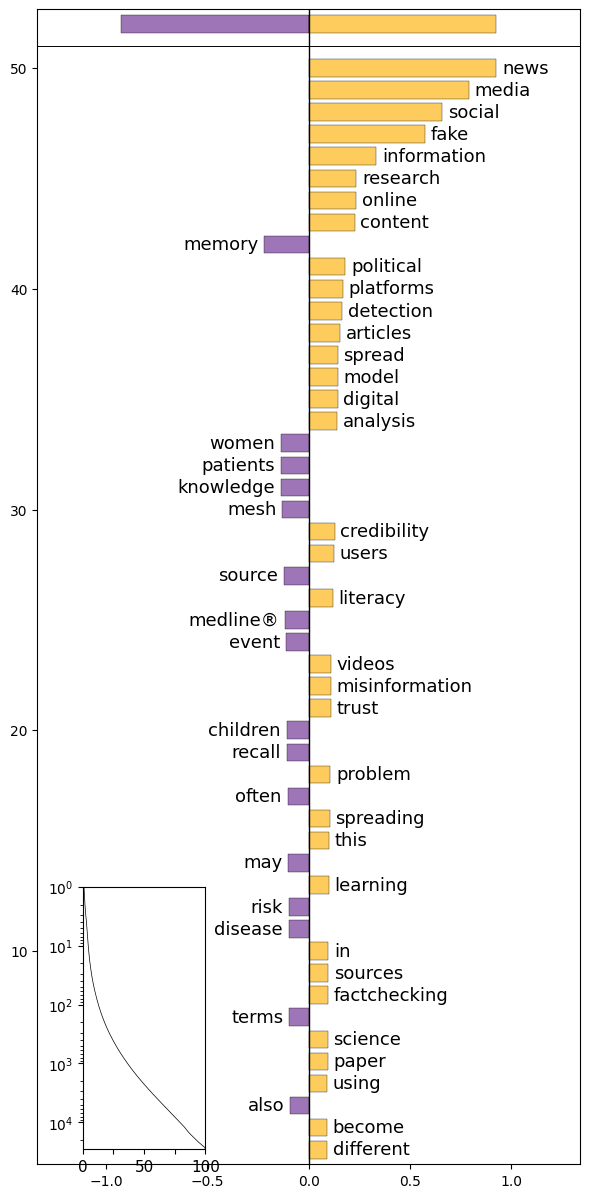

In [21]:
import shifterator as sh
proportion_shift = sh.ProportionShift(type2freq_1=old,
                                      type2freq_2=new)
proportion_shift.get_shift_graph()

# Note, this always produces this Error. Please ignore! I'll put in a PR to fix one of these days...

This is so interesting! You can really see the change! Before 2016, there's a lot of qualitative work on misinformation with a focus on anti-vaccine things (which, I suspect, is where "women" comes from). The entire concept changes from _medical_ misinformation to _political_ misinformation. I love this graph!

AttributeError: 'YTick' object has no attribute 'label'

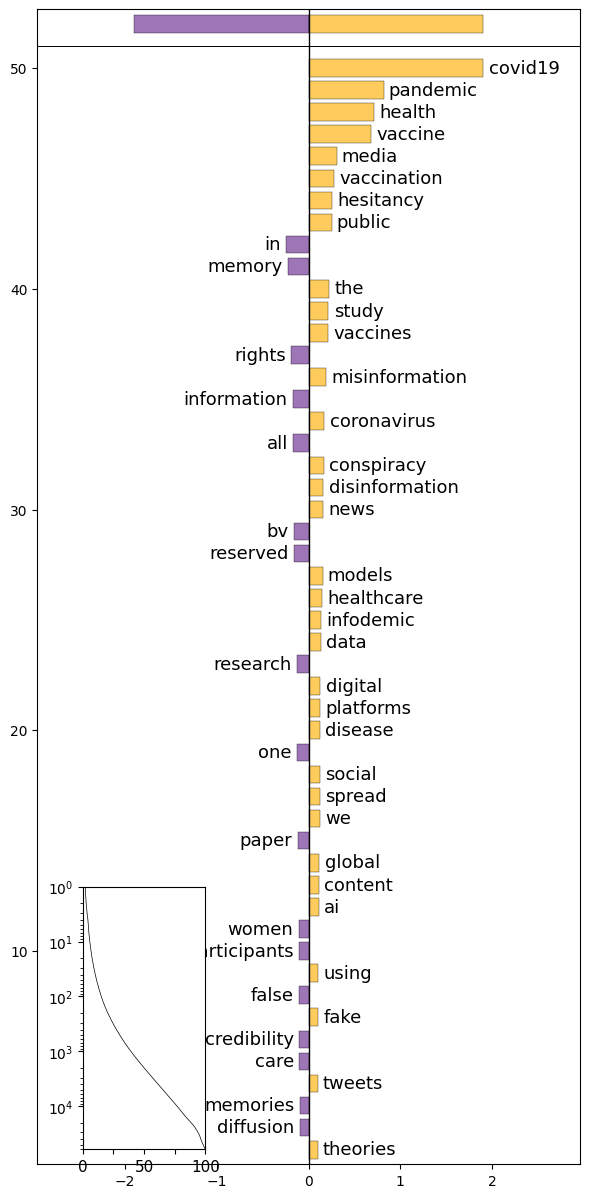

In [28]:
proportion_shift = sh.ProportionShift(type2freq_1=new,
                                      type2freq_2=covid)
proportion_shift.get_shift_graph()

I also wonder if we can see the same changes in the kinds of researchers doing this work. Maybe if I look at the affiliations, we'll see a shift from public health to computer science. Most affiliations just have the university, but maybe we can do some quick and dirty string parsing to explore.

In [22]:
affiliation_and_year = df[df.Affiliations.astype(str).str.lower().str.contains('department')][['Affiliations', 'Year']]
csv_data = affiliation_and_year.to_csv()

In [23]:
import re
pattern = re.compile(r"department of ([a-zA-Z ]+)|division of ([a-zA-Z ]+)")
from io import StringIO
import csv

special_health_keywords = ['hospital', 'medicine', 'disease', 'hygiene', 'health', 'medical', 'vaccine']
special_computer_keywords = ['computer']

def extract_departments(csvtext):
    f = StringIO(csvtext)
    reader = csv.reader(f, delimiter=',')
    data = {'year':[], 'department':[]}
    for i, row in enumerate(reader):
        if i == 0:
            continue
            
        affiliations = row[1]
        for affiliation in affiliations.split(';'):
            affiliation = affiliation.lower()
            match = re.findall(pattern, affiliation)
 #           if not match:
 #               if any([word in affiliation for word in special_health_keywords]):
 #                   data['year'].append(int(row[2]))
 #                   data['department'].append('health')
 #               elif any([word in affiliation for word in special_computer_keywords]):
 #                   data['year'].append(int(row[2]))
 #                   data['department'].append('computer')
 #           else:
            for departments in match:
                for dept in departments:
                    if dept:
                        data['year'].append(int(row[2]))
                        data['department'].append(dept)
                    
    return data
            

data = extract_departments(csv_data)
        
        

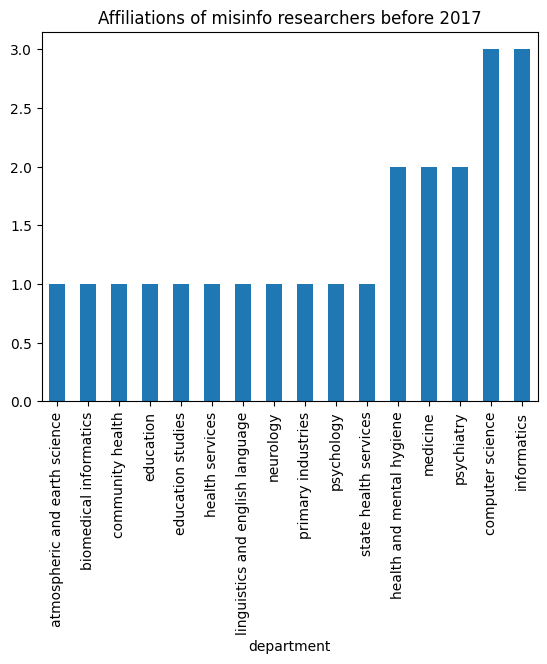

In [50]:
import matplotlib.pyplot as plt
year_to_dept = pd.DataFrame(data)
fig, ax = plt.subplots()


ax = year_to_dept[
    year_to_dept.year <= 2016
].groupby(year_to_dept.department).count()['department'].sort_values().plot(
    ax=ax, 
    kind='bar',
    title="Affiliations of misinfo researchers before 2017"
)


<Axes: title={'center': 'Affiliations of misinfo researchers 2017-2019'}, xlabel='department'>

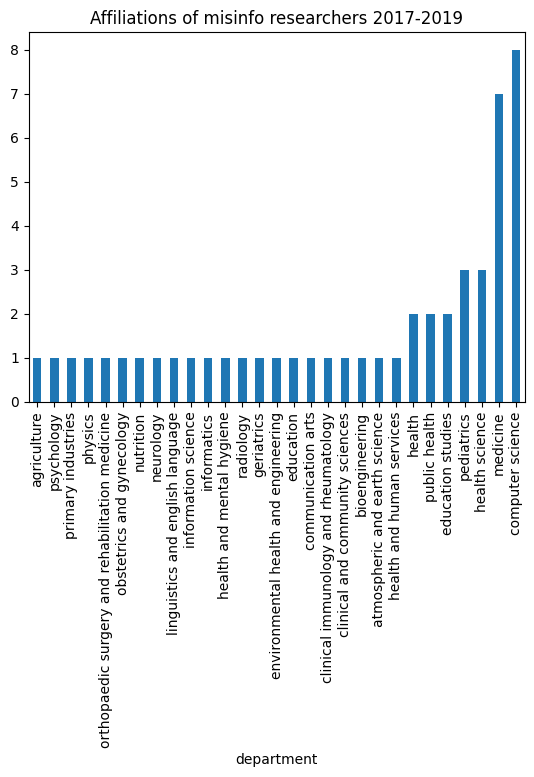

In [51]:
#newstuff = year_to_dept[year_to_dept.year.between(2016, 2021)].groupby(year_to_dept.department).size().reset_index(name="count")
#newstuff[newstuff['count']>3].sort_values('count').plot('department', 'count', kind='bar')
#newstuff[newstuff['count']>3]['count'].plot(ax=ax, kind='bar')
fig, ax = plt.subplots()

year_to_dept[year_to_dept.year.between(2016, 2020)].groupby(year_to_dept.department).count()['department'].sort_values().plot(
    ax=ax, kind='bar', title="Affiliations of misinfo researchers 2017-2019"

)


Examining the data further, I think that this is a dead end. The data is too messy. For example, many affiliations are to hospitals, whereas many computer scientists are just affiliated to the university, so there's no useful way to compare the affiliatio data.

# Word embeddings

If I want to look at how concepts are changing, what better way to do that than word embeddings? 

**NOTE**: Due to a dependencies mismatch, I've had to break this notebook into 2 so that I can work in different environments. I've recombined the PDFs, but this is why there's a gap and then I'll be re-importing the same things.
